In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

#### Geospatial dataset Source

Original source vailable https://centrodedescargas.cnig.es/CentroDescargas/limites-municipales-provinciales-autonomicos
- Two shapefiles were extracted from this dataset containing only autonomous communities and province information, respectively
- Unuseful columns were removed
- Both tables were merged using an artificial ID for each aacc sorted alphabetically

#### Demographic datasets Sources
##### Wage earners by economic sector, sex and Autonomous Community. Percentages with respects to the total of each community.: 
https://datos.gob.es/en/catalogo/ea0010587-asalariados-por-sector-economico-sexo-y-comunidad-autonoma-porcentajes-respecto-del-total-de-cada-comunidad-epa-identificador-api-66046

##### Number of job vacancies by Autonomous Community: 
https://datos.gob.es/en/catalogo/ea0010587-numero-de-vacantes-comunidad-autonoma-etcl-identificador-api-6064


#### DATASET: Number of job vacancies

In [31]:
jobs = pd.read_csv('number_job_vacancies_by_ACC.csv', sep=";")
jobs.tail()

,Total Nacional,Comunidades y Ciudades Autónomas,Periodo,Total
823,Total Nacional,"17 Rioja, La",2014T3,206.0
824,Total Nacional,"17 Rioja, La",2014T2,159.0
825,Total Nacional,"17 Rioja, La",2014T1,596.0
826,Total Nacional,"17 Rioja, La",2013T4,194.0
827,Total Nacional,"17 Rioja, La",2013T3,333.0


In [32]:
jobs[['Año', 'Trimestre']] = jobs['Periodo'].str.extract(r'(\d{4})(T\d)')
jobs = jobs.drop('Periodo', axis=1) # Remove column with incorrect data format
jobs.drop('Total Nacional', axis=1, inplace=True) # Remove unused data

jobs.head()

,Comunidades y Ciudades Autónomas,Total,Año,Trimestre
0,NaN,148.018,2024,T4
1,NaN,150.541,2024,T3
2,NaN,151.379,2024,T2
3,NaN,149.962,2024,T1
4,NaN,139.314,2023,T4


##### Missing Values Handling

In [43]:
jobs[['Comunidades y Ciudades Autónomas']].value_counts()
jobs[jobs['Comunidades y Ciudades Autónomas'].isna()]

#Critical missing datapoints were removed
jobs= jobs.dropna()
jobs.head()
jobs.shape

(782, 4)

##### Managing data types

In [41]:
jobs['Año'] = jobs['Año'].astype(int)
jobs['Trimestre'] = jobs['Trimestre'].astype('category')
jobs.dtypes

Comunidades y Ciudades Autónomas      object
Total                                float64
Año                                    int64
Trimestre                           category
dtype: object

#### DATASET: Wage by economic sector

In [44]:
wage = pd.read_csv('wage_by_economic_sector_sex_AACC.csv', sep=";")
wage.head()

,Sexo,Comunidades y Ciudades Autónomas,Sector económico,Periodo,Total
0,Ambos sexos,Total Nacional,Total,2024,100
1,Ambos sexos,Total Nacional,Total,2023,100
2,Ambos sexos,Total Nacional,Total,2022,100
3,Ambos sexos,Total Nacional,Total,2021,100
4,Ambos sexos,Total Nacional,Total,2020,100


In [45]:
wage.isna().sum()

Sexo                                0
Comunidades y Ciudades Autónomas    0
Sector económico                    0
Periodo                             0
Total                               0
dtype: int64

In [46]:
wage[['Sexo']].value_counts()
wage[['Comunidades y Ciudades Autónomas']].value_counts()
wage[['Sector económico']].value_counts()
wage[['Periodo']].value_counts()

Periodo
2008       300
2017       300
2023       300
2022       300
2021       300
2020       300
2019       300
2018       300
2016       300
2009       300
2015       300
2014       300
2013       300
2012       300
2011       300
2010       300
2024       300
Name: count, dtype: int64

#### Removing unused data

In [47]:
wage = wage[wage['Sector económico'] != 'Total']

In [48]:
wage = wage[wage['Comunidades y Ciudades Autónomas'] != 'Total Nacional']

In [49]:
wage = wage[wage['Total'] != '..']

#### Basic formatting

In [50]:
wage['Total'] = wage['Total'].str.replace(',', '.', regex=False)
wage['Total'] = wage['Total'].astype(float)

In [15]:
# Making datasets comparable between each other
wage = wage[wage['Periodo'] >= 2013]
wage[['Comunidades y Ciudades Autónomas']].value_counts()

Comunidades y Ciudades Autónomas
01 Andalucía                        144
02 Aragón                           144
17 Rioja, La                        144
16 País Vasco                       144
15 Navarra, Comunidad Foral de      144
14 Murcia, Región de                144
12 Galicia                          144
11 Extremadura                      144
10 Comunitat Valenciana             144
09 Cataluña                         144
08 Castilla - La Mancha             144
07 Castilla y León                  144
06 Cantabria                        144
05 Canarias                         144
13 Madrid, Comunidad de             143
03 Asturias, Principado de          143
04 Balears, Illes                   142
19 Melilla                          112
18 Ceuta                            108
Name: count, dtype: int64

### Geospatial information

In [51]:
aacc_path='geospatial_info/aacc/autonomous_communities.shp'
aacc = gpd.read_file(aacc_path)

##### Geospatial DataFrame for Jobs information

In [56]:
# Set names for AACC in JOBS using the convention in the shapefile (which is clean)

names_mapped = {
    '01 Andalucía': 'Andalucía',
    '02 Aragón': 'Aragón',
    '03 Asturias, Principado de': 'Principado de Asturias',
    '04 Balears, Illes': 'Illes Balears',
    '05 Canarias': 'Canarias',
    '06 Cantabria': 'Cantabria',
    '07 Castilla y León': 'Castilla y León',
    '08 Castilla - La Mancha': 'Castilla-La Mancha',
    '09 Cataluña': 'Cataluña/Catalunya',
    '10 Comunitat Valenciana': 'Comunitat Valenciana',
    '11 Extremadura': 'Extremadura',
    '12 Galicia': 'Galicia',
    '13 Madrid, Comunidad de': 'Comunidad de Madrid',
    '14 Murcia, Región de': 'Región de Murcia',
    '15 Navarra, Comunidad Foral de': 'Comunidad Foral de Navarra',
    '16 País Vasco': 'País Vasco/Euskadi',
    '17 Rioja, La': 'La Rioja'
}
jobs.loc[:, 'autonomous_c'] = jobs['Comunidades y Ciudades Autónomas'].map(names_mapped)
# Merge  original wage dataset and geospatial dataset
jobs_geo = jobs.merge(aacc, how="left", left_on="autonomous_c", right_on="NAMEUNIT")
# Remove unused columns
jobs_geo = jobs_geo.drop(['Comunidades y Ciudades Autónomas','NATLEVNAME'], axis=1)
# Transform DF to GeoDataFrame
jobs_geo = gpd.GeoDataFrame(jobs_geo, geometry='geometry')

##### Geospatial DataFrame for Wage information

In [57]:
# Set names for AACC in the WAGE dataset using the convention in the shapefile (which has been cleaned)

names_map = {
    '01 Andalucía': 'Andalucía',
    '02 Aragón': 'Aragón',
    '03 Asturias, Principado de': 'Principado de Asturias',
    '04 Balears, Illes': 'Illes Balears',
    '05 Canarias': 'Canarias',
    '06 Cantabria': 'Cantabria',
    '07 Castilla y León': 'Castilla y León',
    '08 Castilla - La Mancha': 'Castilla-La Mancha',
    '09 Cataluña': 'Cataluña/Catalunya',
    '10 Comunitat Valenciana': 'Comunitat Valenciana',
    '11 Extremadura': 'Extremadura',
    '12 Galicia': 'Galicia',
    '13 Madrid, Comunidad de': 'Comunidad de Madrid',
    '14 Murcia, Región de': 'Región de Murcia',
    '15 Navarra, Comunidad Foral de': 'Comunidad Foral de Navarra',
    '16 País Vasco': 'País Vasco/Euskadi',
    '17 Rioja, La': 'La Rioja',
    '18 Ceuta': 'Ciudad Autónoma de Ceuta',
    '19 Melilla': 'Ciudad Autónoma de Melilla'
}
# Estandardize the name of the Autonomous Communities
wage.loc[:, 'autonomous_c'] = wage['Comunidades y Ciudades Autónomas'].map(names_map)
# Merge  original wage dataset and geospatial dataset
wage_geo = wage.merge(aacc, how="left", left_on="autonomous_c", right_on="NAMEUNIT")
# Remove unused columns
wage_geo = wage_geo.drop(['Comunidades y Ciudades Autónomas','NATLEVNAME'], axis=1)
# Transform DF to GeoDataFrame
wage_geo = gpd.GeoDataFrame(wage_geo, geometry='geometry')

#### Wage dataset segmentation

In [58]:
# Select one economic sector, year and gender category - Agriculture in 2024 for Both Genders
agri = wage_geo[(wage_geo['Sector económico'] == 'Agricultura') & 
                (wage_geo['Sexo'] == 'Ambos sexos') & 
                (wage_geo['Periodo'] == 2024)]

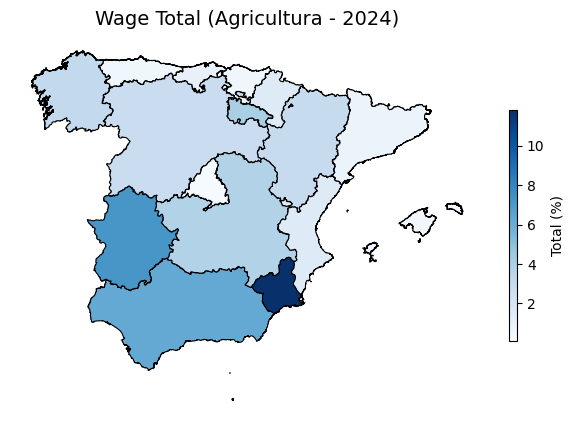

In [59]:
import matplotlib.colors as mcolors
# Normalize values for visualization
vmin = agri['Total'].min()
vmax = agri['Total'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
agri.plot(
    column='Total',
    cmap='Blues',
    linewidth=0.8,
    edgecolor='black',
    ax=ax,
    legend=True,
    norm=norm,
    legend_kwds={
        'shrink': 0.6,
        'fraction': 0.03,
        'pad': 0.04,
        'aspect': 30,
        'label': 'Total (%)'
    }
)
ax.set_title('Wage Total (Agricultura - 2024)', fontsize=14)
ax.axis('off')
plt.show()

### Visualization of subplots by Economic sector

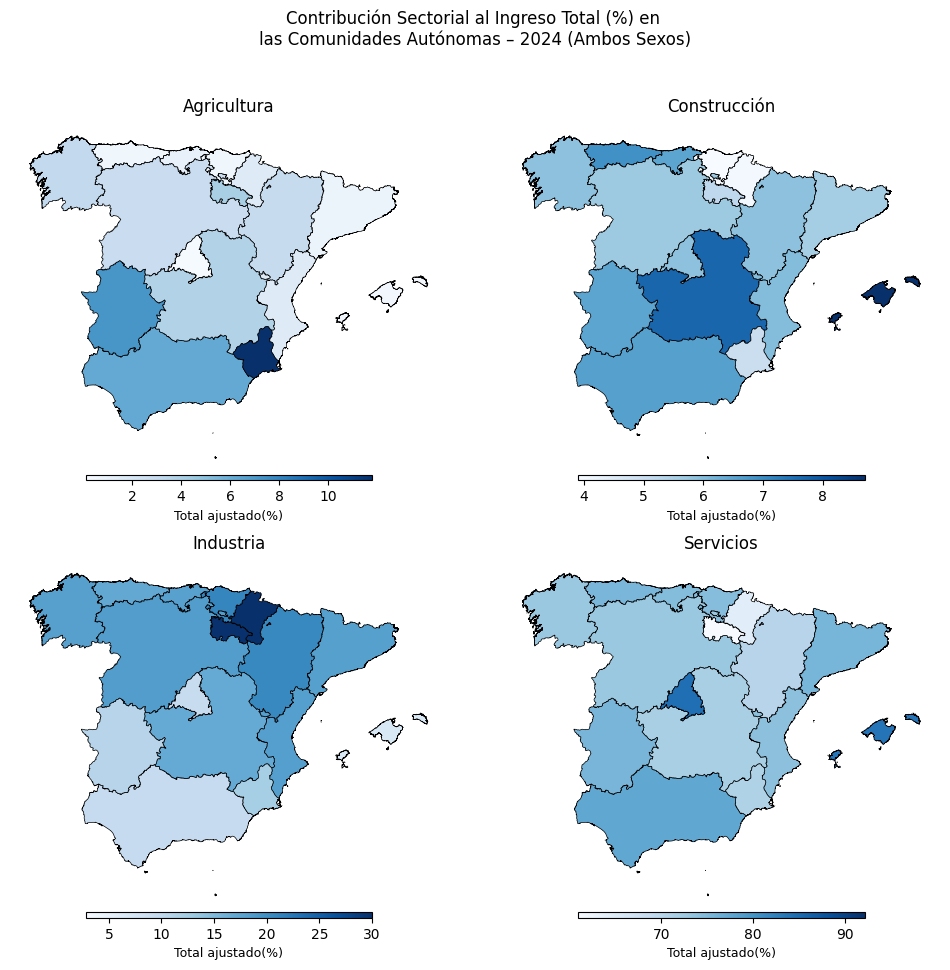

In [60]:
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# Data segmentation
data_2024 = wage_geo[
    (wage_geo['Periodo'] == 2024) &
    (wage_geo['Sexo'] == 'Ambos sexos')
]
# Prepare data for subplots - sort by unique names and calculate number and arrange of subplots
sectores = sorted(data_2024['Sector económico'].unique())
n = len(sectores)
cols = 2
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for i, sector in enumerate(sectores):
    ax = axes[i]
    sector_data = data_2024[data_2024['Sector económico'] == sector]

    # Normalization by sector
    vmin = sector_data['Total'].min()
    vmax = sector_data['Total'].max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Map by economic sector
    sector_data.plot(
        column='Total',
        cmap='Blues',
        linewidth=0.5,
        edgecolor='black',
        ax=ax,
        legend=False,
        norm=norm
    )

    ax.set_title(sector, fontsize=12)
    ax.axis('off')

    # Legend
    sm = ScalarMappable(cmap='Blues', norm=norm)
    sm._A = []
    cbar = fig.colorbar(
        sm,
        ax=ax,
        orientation='horizontal',
        shrink=0.6,    
        pad=0,      
        aspect=50
    )
    cbar.set_label('Total ajustado(%)', fontsize=9)

#plt.suptitle('Sectoral Contribution to Total Income (%) in \nAutonomous Communities – 2024 (Both Genders)', fontsize=12)
plt.suptitle('Contribución Sectorial al Ingreso Total (%) en \nlas Comunidades Autónomas – 2024 (Ambos Sexos)', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Basic statistics to complement

In [68]:
#stats = wage.groupby('Sector económico')['Total'].describe()
stats_2024 = wage[wage['Periodo'] == 2024].groupby('Sector económico')['Total'].describe()

stats_2024

,count,mean,std,min,25%,50%,75%,max
Sector económico,,,,,,,,
Agricultura,53.0,2.847170,3.312018,0.1,0.700,1.6,3.8,16.4
Construcción,57.0,5.826316,4.002880,0.8,1.600,5.9,8.7,15.4
Industria,56.0,15.162500,9.726619,1.8,6.875,12.3,20.8,41.7
Servicios,57.0,76.626316,13.337079,46.4,65.200,76.3,87.3,99.2


In [66]:
wage.head()

,Sexo,Comunidades y Ciudades Autónomas,Sector económico,Periodo,Total,autonomous_c
102,Ambos sexos,01 Andalucía,Agricultura,2024,6.2,Andalucía
103,Ambos sexos,01 Andalucía,Agricultura,2023,6.4,Andalucía
104,Ambos sexos,01 Andalucía,Agricultura,2022,6.8,Andalucía
105,Ambos sexos,01 Andalucía,Agricultura,2021,8.1,Andalucía
106,Ambos sexos,01 Andalucía,Agricultura,2020,8.1,Andalucía
